### Configuration: number of files and data delivery path

In [1]:
# GLOBAL CONFIGURATION
N_FILES_MAX_PER_SAMPLE = 10  # input files per process, set to e.g. 10 (smaller number = faster)
USE_SERVICEX = False
USE_DASK = True  # not enabled when using ServiceX processors in coffea
SERVICEX_IGNORE_CACHE = True  # set to True to force re-running of transforms
AF = "coffea_casa"  # set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups

### Imports: setting up our environment

In [2]:
import asyncio
import time
import logging

import awkward as ak
import vector; vector.register_awkward()
from coffea import processor
from coffea.processor import servicex
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import transforms
from func_adl import ObjectStream
import hist
import json
import numpy as np
import uproot
import cabinetry
from coffea.nanoevents.schemas.base import BaseSchema
import matplotlib.pyplot as plt

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.getLogger("cabinetry").setLevel(logging.INFO)

### Defining our `coffea` Processor

The processor includes a lot of the physics analysis details:
- event filtering and the calculation of observables,
- event weighting,
- calculating systematic uncertainties at the event and object level,
- filling all the information into histograms that get aggregated and ultimately returned to us by `coffea`.

In [3]:
processor_base = processor.ProcessorABC if not USE_SERVICEX else servicex.Analysis

# functions creating systematic variations
def flat_variation(ones):
    # 1% weight variations
    return (1.0 + np.array([0.01, -0.01], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (10% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.1, -0.1]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()
            
    
def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


class TtbarAnalysis(processor_base):
    def __init__(self):
        num_bins = 25
        bin_low = 50
        bin_high = 550
        name = "observable"
        label = "observable [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )

    def process(self, events):
        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1
        
        #### systematics
        # example of a simple flat weight variation
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)

        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.jet.pt)
                
        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
    
            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # pT > 25 GeV for leptons & jets
            selected_electrons = events.electron[events.electron.pt > 25]
            selected_muons = events.muon[events.muon.pt > 25]
            jet_filter = events.jet.pt * events[pt_var] > 25  # pT > 25 GeV for jets (scaled by systematic variations)
            selected_jets = events.jet[jet_filter]  

            # single lepton requirement
            event_filters = (ak.count(selected_electrons.pt, axis=1) & ak.count(selected_muons.pt, axis=1) == 1)
            # at least four jets
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            # at least one b-tagged jet ("tag" means score above threshold)
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)

            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]

            for region in ["4j1b", "4j2b"]:
                # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
                if region == "4j1b":
                    region_filter = ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) == 1
                    selected_jets_region = selected_jets[region_filter]
                    # use HT (scalar sum of jet pT) as observable
                    pt_var_modifier = events[event_filters][region_filter][pt_var] if "res" not in pt_var else events[pt_var][jet_filter][event_filters][region_filter]
                    observable = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)

                elif region == "4j2b":
                    region_filter = ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2
                    selected_jets_region = selected_jets[region_filter]

                    if USE_SERVICEX:
                        # wrap into a four-vector object to allow addition
                        selected_jets_region = ak.zip(
                            {
                                "pt": selected_jets_region.pt, "eta": selected_jets_region.eta, "phi": selected_jets_region.phi,
                                "mass": selected_jets_region.mass, "btag": selected_jets_region.btag,
                            },
                            with_name="Momentum4D",
                        )

                    # reconstruct hadronic top as bjj system with largest pT
                    # the jet energy scale / resolution effect is not propagated to this observable at the moment
                    trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)

                ### histogram filling
                if pt_var == "pt_nominal":
                    # nominal pT, but including 2-point systematics
                    histogram.fill(
                            observable=observable, region=region, process=process, variation=variation, weight=xsec_weight
                        )
        
                    if variation == "nominal":
                        # also fill weight-based variations for all nominal samples
                        for weight_name in events.systematics.fields:
                            for direction in ["up", "down"]:
                                # extract the weight variations and apply all event & region filters
                                weight_variation = events.systematics[weight_name][direction][f"weight_{weight_name}"][event_filters][region_filter]
                                # fill histograms
                                histogram.fill(
                                    observable=observable, region=region, process=process, variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                        # calculate additional systematics: b-tagging variations
                        for i_var, weight_name in enumerate([f"btag_var_{i}" for i in range(4)]):
                            for i_dir, direction in enumerate(["up", "down"]):
                                # create systematic variations that depend on object properties (here: jet pT)
                                weight_variation = btag_weight_variation(i_var, selected_jets_region.pt)[:, 1-i_dir]
                                histogram.fill(
                                    observable=observable, region=region, process=process, variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                elif variation == "nominal":
                    # pT variations for nominal samples
                    histogram.fill(
                            observable=observable, region=region, process=process, variation=pt_var, weight=xsec_weight
                        )

        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

### AGC `coffea` schema

When using `coffea`, we can benefit from the schema functionality to group columns into convenient objects.
This schema is taken from [mat-adamec/agc_coffea](https://github.com/mat-adamec/agc_coffea).

In [4]:
class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [5]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneCUETP8M1_13TeV-powheg-pythia8/MINIAODSIM//PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1/00000/00DF0A73-17C2-E511-B086-E41D2D08DE30.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 442122, 'xsec': 729.84}
}


### ServiceX-specific functionality: query setup

Define the func_adl query to be used for the purpose of extracting columns and filtering.

In [6]:
def get_query(source: ObjectStream) -> ObjectStream:
    """Query for event / column selection: no filter, select all columns
    """
    return source.Select(lambda e: {
                                    "electron_pt": e.electron_pt,
                                    "muon_pt": e.muon_pt,
                                    "jet_pt": e.jet_pt,
                                    "jet_eta": e.jet_eta,
                                    "jet_phi": e.jet_phi,
                                    "jet_mass": e.jet_mass,
                                    "jet_btag": e.jet_btag,
                                   }
                        )

### Via servicex-databinder (separate ServiceX + coffea)

** This is work in progress **

In [7]:
from servicex_databinder import DataBinder
query_string = """Select(lambda e: {
                    'electron_pt': e.electron_pt,
                    'jet_pt': e.jet_pt,
                    'jet_eta': e.jet_eta,
                    'jet_phi': e.jet_phi,
                    'jet_mass': e.jet_mass,
                    'jet_btag': e.jet_btag})"""

# from servicex_databinder import DataBinder

databinder_config = {"General": {"ServiceXBackendName": "uproot",
                                 "OutputDirectory": "outputs",
                                 "OutputFormat": "parquet",
                                 "IgnoreServiceXCache": True},
                     "Sample": [
                         {
                             "Name": "single_top_s_chan__nominal",
                             "RucioDID": "user.ivukotic:user.ivukotic.single_top_s_chan__nominal",
                             "Tree": "events",
                             "FuncADL": query_string
                         }
                     ]
                    }

# sx_db = DataBinder(databinder_config)
# out = sx_db.deliver()

# update list of fileset files, pointing to ServiceX output
# for process in fileset.keys():
#     fileset[process]["files"] = out[process]["events"]

### Execute the data delivery pipeline

What happens here depends on the configuration:
- with `USE_SERVICEX` enabled, ServiceX will feed columns to `coffea` processors, which will asynchronously process them and accumulate the output histograms,
- with it disabled, `coffea` will directly process the input data from the source.

In [8]:
t0 = time.time()

if USE_SERVICEX:
    # dask is not yet supported in this setup
        
    # in a notebook:
    all_histograms = await utils.produce_all_histograms(fileset, get_query, TtbarAnalysis, use_dask=False, ignore_cache=SERVICEX_IGNORE_CACHE)

    # as a script:
    # async def produce_all_the_histograms(fileset):
    #    return await utils.produce_all_histograms(fileset, use_dask=False)
    #
    # all_histograms = asyncio.run(produce_all_the_histograms(fileset))

else:
    if USE_DASK:
        executor = processor.DaskExecutor(client=utils.get_client(AF))
    else:
        executor = processor.IterativeExecutor()

    run = processor.Runner(executor=executor, schema=AGCSchema, savemetrics=True, metadata_cache={})

    all_histograms, metrics = run(fileset, "events", processor_instance=TtbarAnalysis())
    all_histograms = all_histograms["hist"]
    
print(f"\nexecution took {time.time() - t0:.2f} seconds")

[########################################] | 100% Completed | 36.0s
execution took 53.30 seconds


### Inspecting the produced histograms

Let's have a look at the data we obtained.
We built histograms in two phase space regions, for multiple physics processes and systematic variations.

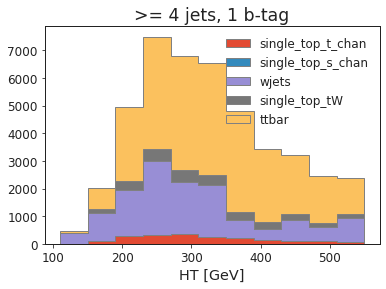

In [9]:
utils.set_style()

all_histograms[120j::hist.rebin(2), "4j1b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, 1 b-tag")
plt.xlabel("HT [GeV]");

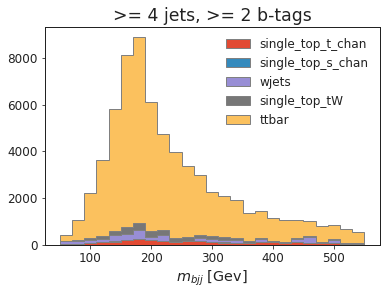

In [10]:
all_histograms[:, "4j2b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags");
plt.xlabel("$m_{bjj}$ [Gev]");

Let's also have a look at some systematic variations:
- b-tagging, which we implemented as jet-kinematic dependent event weights,
- jet energy variations, which vary jet kinematics, resulting in acceptance effects and observable changes.

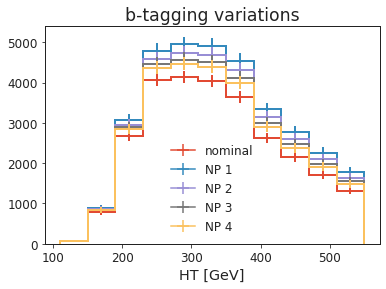

In [11]:
# b-tagging variations
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_0_down"].plot(label="NP 1", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_1_down"].plot(label="NP 2", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_2_down"].plot(label="NP 3", linewidth=2)
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "btag_var_3_down"].plot(label="NP 4", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("HT [GeV]")
plt.title("b-tagging variations");

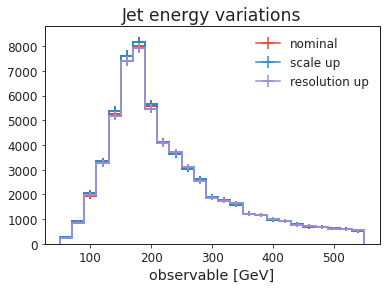

In [12]:
# jet energy scale variations
all_histograms[:, "4j2b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
all_histograms[:, "4j2b", "ttbar", "pt_scale_up"].plot(label="scale up", linewidth=2)
all_histograms[:, "4j2b", "ttbar", "pt_res_up"].plot(label="resolution up", linewidth=2)
plt.legend(frameon=False)
plt.title("Jet energy variations");

### Save histograms to disk

We'll save everything to disk for subsequent usage.
This also builds pseudo-data by combining events from the various simulation setups we have processed.

In [13]:
utils.save_histograms(all_histograms, fileset, "histograms.root")

### Statistical inference

A statistical model has been defined in `config.yml`, ready to be used with our output.
We will use `cabinetry` to combine all histograms into a `pyhf` workspace and fit the resulting statistical model to the pseudodata we built.

INFO - opening config file config.yml
INFO - building workspace
INFO - performing maximum likelihood fit
INFO - MINUIT status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 167.5                      │             Nfcn = 5450              │
│ EDM = 0.000156 (Goal: 0.0002)    │            time = 1.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴─

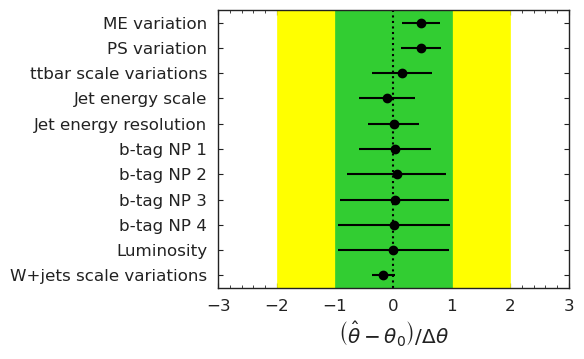

In [14]:
config = cabinetry.configuration.load("config.yml")
cabinetry.templates.collect(config)
cabinetry.templates.postprocess(config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(config)
cabinetry.workspace.save(ws, "ws.json")

model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude="ttbar_norm", close_figure=True, save_figure=False
)

For this pseudodata, what is the resulting ttbar cross-section divided by the Standard Model prediction?

In [15]:
print(f"\nfit result for ttbar_norm: {fit_results.bestfit[model.config.poi_index]:.3f} +/- {fit_results.uncertainty[model.config.poi_index]:.3f}")


fit result for ttbar_norm: 0.964 +/- 0.161


Let's also visualize the model before and after the fit, in both the regions we are using.
The binning here corresponds to the binning used for the fit.

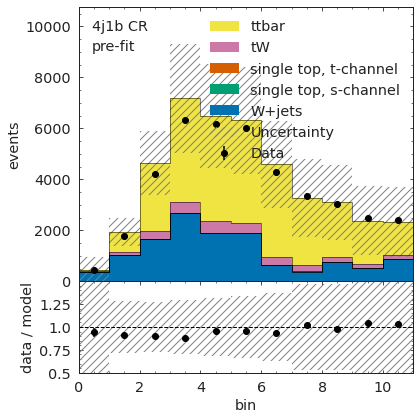

In [16]:
model_prediction = cabinetry.model_utils.prediction(model)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True)
figs[0]["figure"]

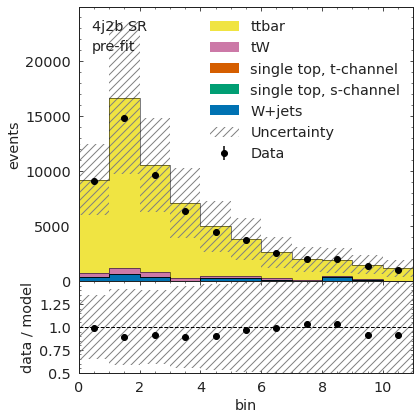

In [17]:
figs[1]["figure"]

We can see very good post-fit agreement.

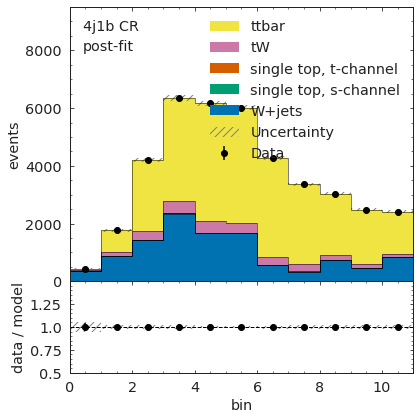

In [18]:
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction_postfit, data, close_figure=True)
figs[0]["figure"]

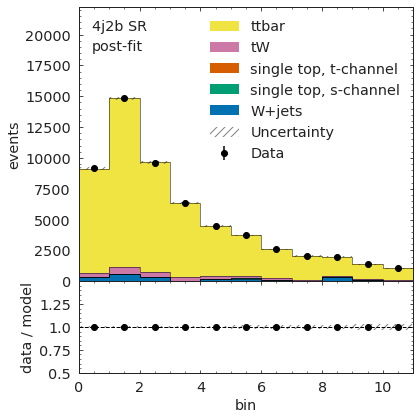

In [19]:
figs[1]["figure"]